# Model Explorer

Interactive notebook for understanding the 1D CNN gravitational wave detection model.

**Sections:**
1. Setup - Load model, data, and dependencies
2. Single Sample Basics - Understand one sample end-to-end
3. Batch Understanding - Analyze model behavior across many samples
4. Error Analysis - Understand where the model fails
5. Time-Frequency Visualizations - Spectrograms and cross-detector correlation
6. Model Interpretability - Grad-CAM, activations, learned filters
7. Interactive Playground - Free exploration

# ============================================================================================
#                                   SECTION 1: SETUP
# ============================================================================================

In [ ]:
import sys
from pathlib import Path

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy import signal

# add src to path
PROJECT_ROOT = Path.cwd().parent
SRC_DIR = PROJECT_ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

from data import (
    find_dataset_dir, load_labels, load_sample,
    preprocess_sample, bandpass_filter, whiten_signal, apply_tukey_window,
    load_psd, FS, N, N_FREQ
)
from models.diy_model import DIYModel
from visualization import (
    plot_confusion_matrix, plot_prediction_distribution,
    plot_roc_curve, plot_precision_recall_curve
)

print(f"TensorFlow version: {tf.__version__}")
print(f"Project root: {PROJECT_ROOT}")

In [ ]:
# -----------------------------------------------------------------------------
#                               model discovery
# -----------------------------------------------------------------------------

MODELS_DIR = PROJECT_ROOT / "kaggle" / "output" / "models" / "saved"
PSD_PATH = PROJECT_ROOT / "kaggle" / "output" / "avg_psd.npz"


def find_available_models(models_dir=MODELS_DIR):
    """
    Find all available model weights in the models directory.
    
    Returns
    -------
    list of dict
        Each dict contains 'date', 'weights_path', 'config_path', 'metrics_path'
    """
    models = []
    
    if not models_dir.exists():
        print(f"Models directory not found: {models_dir}")
        return models
    
    for weights_file in models_dir.glob("diy_*_weights.npz"):
        # extract date from filename: diy_20260126_1842_weights.npz -> 20260126_1842
        name = weights_file.stem  # diy_20260126_1842_weights
        parts = name.replace("diy_", "").replace("_weights", "")
        date = parts  # 20260126_1842
        
        config_path = models_dir / f"diy_{date}_config.json"
        metrics_path = models_dir / f"diy_{date}_metrics.json"
        
        models.append({
            'date': date,
            'weights_path': weights_file,
            'config_path': config_path if config_path.exists() else None,
            'metrics_path': metrics_path if metrics_path.exists() else None,
        })
    
    # sort by date (most recent first)
    models.sort(key=lambda x: x['date'], reverse=True)
    return models


def get_model_by_date(date=None, models_dir=MODELS_DIR):
    """
    Get model paths by date. If date is None, returns the latest model.
    
    Parameters
    ----------
    date : str, optional
        Model date in format 'YYYYMMDD_HHMM' (e.g., '20260126_1842').
        If None, returns the latest model.
    
    Returns
    -------
    dict or None
        Model info dict with 'date', 'weights_path', 'config_path', 'metrics_path'
    """
    models = find_available_models(models_dir)
    
    if not models:
        return None
    
    if date is None:
        return models[0]  # latest
    
    for model in models:
        if model['date'] == date:
            return model
    
    print(f"Model with date '{date}' not found.")
    print(f"Available dates: {[m['date'] for m in models]}")
    return None


def load_model_config(config_path):
    """Load model configuration from JSON file."""
    import json
    if config_path and config_path.exists():
        with open(config_path) as f:
            return json.load(f)
    return None


# list available models
available_models = find_available_models()
print("AVAILABLE MODELS")
print("="*60)
if available_models:
    for i, m in enumerate(available_models):
        latest_tag = " (latest)" if i == 0 else ""
        print(f"  {m['date']}{latest_tag}")
else:
    print("  No models found.")
print()

In [ ]:
# -----------------------------------------------------------------------------
#                         model selection configuration
# -----------------------------------------------------------------------------
# Change MODEL_DATE to analyze a different model.
# Set to None for the latest model, or specify a date like '20260117_2309'

MODEL_DATE = None  # None = latest model, or e.g. '20260117_2309'

# validation configuration
N_VAL_SAMPLES = 1000  # number of validation samples to load
DETECTORS = ['H1', 'L1', 'V1']

# load selected model info
selected_model = get_model_by_date(MODEL_DATE)

if selected_model:
    print(f"Selected model: {selected_model['date']}")
    print(f"  Weights: {selected_model['weights_path'].name}")
    
    # load config if available
    saved_config = load_model_config(selected_model['config_path'])
    if saved_config:
        MODEL_CONFIG = {
            'n_samples': saved_config.get('n_samples', 4096),
            'learning_rate': saved_config.get('learning_rate', 0.0001),
            'dropout_rate': saved_config.get('dropout_rate', 0.5),
        }
    else:
        # default config
        MODEL_CONFIG = {
            'n_samples': 4096,
            'learning_rate': 0.0001,
            'dropout_rate': 0.5,
        }
        print("  Config file not found, using defaults.")
else:
    print("ERROR: No model found!")
    MODEL_CONFIG = {'n_samples': 4096, 'learning_rate': 0.0001, 'dropout_rate': 0.5}
    saved_config = None

In [ ]:
# -----------------------------------------------------------------------------
#                               load model
# -----------------------------------------------------------------------------

model = DIYModel(
    n_samples=MODEL_CONFIG['n_samples'],
    learning_rate=MODEL_CONFIG['learning_rate'],
    dropout_rate=MODEL_CONFIG['dropout_rate']
)

if selected_model and selected_model['weights_path'].exists():
    model.load_weights(str(selected_model['weights_path']))
    print(f"Model weights loaded: {selected_model['weights_path'].name}")
    print(f"Model date: {selected_model['date']}")
else:
    print("WARNING: No weights loaded. Model initialized with random weights.")

print(f"\nModel configuration:")
for key, value in MODEL_CONFIG.items():
    print(f"  {key}: {value}")

# show saved metrics if available
if selected_model and selected_model['metrics_path']:
    import json
    with open(selected_model['metrics_path']) as f:
        saved_metrics = json.load(f)
    
    if 'val_metrics' in saved_metrics:
        print(f"\nSaved validation metrics:")
        for key, value in saved_metrics['val_metrics'].items():
            print(f"  {key}: {value:.4f}")

In [ ]:
# -----------------------------------------------------------------------------
#                           load average PSD
# -----------------------------------------------------------------------------

if PSD_PATH.exists():
    avg_psd = load_psd(PSD_PATH)
    print(f"Average PSD loaded from: {PSD_PATH.name}")
    print(f"  Shape: {avg_psd.shape}")
else:
    print(f"WARNING: PSD not found at {PSD_PATH}")
    print("Preprocessing will not work correctly without PSD.")
    avg_psd = None

In [ ]:
# -----------------------------------------------------------------------------
#                           load dataset labels
# -----------------------------------------------------------------------------

try:
    dataset_dir = find_dataset_dir()
    labels_df = load_labels(dataset_dir)
    print(f"Dataset found at: {dataset_dir}")
    print(f"Total samples: {len(labels_df)}")
    print(f"  Signal (target=1): {(labels_df['target'] == 1).sum()}")
    print(f"  Noise (target=0): {(labels_df['target'] == 0).sum()}")
except FileNotFoundError as e:
    print(f"Dataset not found: {e}")
    labels_df = None
    dataset_dir = None

In [ ]:
# -----------------------------------------------------------------------------
#                        load validation samples
# -----------------------------------------------------------------------------

import pandas as pd

X_val = None
y_val = None
val_ids = None

if labels_df is not None and dataset_dir is not None and avg_psd is not None:
    print(f"Loading {N_VAL_SAMPLES} validation samples...")
    
    # balanced sampling
    n_per_class = N_VAL_SAMPLES // 2
    signal_samples = labels_df[labels_df['target'] == 1].sample(n=n_per_class, random_state=42)
    noise_samples = labels_df[labels_df['target'] == 0].sample(n=n_per_class, random_state=42)
    val_samples = pd.concat([signal_samples, noise_samples]).sample(frac=1, random_state=42)
    
    X_list = []
    y_list = []
    id_list = []
    
    for _, row in val_samples.iterrows():
        raw = load_sample(row['id'], dataset_dir=dataset_dir)
        processed = preprocess_sample(raw, avg_psd)
        X_list.append(processed)
        y_list.append(row['target'])
        id_list.append(row['id'])
    
    X_val = np.array(X_list)
    y_val = np.array(y_list)
    val_ids = id_list
    
    print(f"Loaded {len(X_val)} samples")
    print(f"  X_val shape: {X_val.shape}")
    print(f"  Signal: {(y_val == 1).sum()}, Noise: {(y_val == 0).sum()}")
else:
    print("Cannot load validation samples (missing dataset or PSD).")

In [ ]:
# -----------------------------------------------------------------------------
#                      helper: switch model (optional)
# -----------------------------------------------------------------------------

def switch_model(date=None):
    """
    Switch to a different model without re-running all setup cells.
    
    Parameters
    ----------
    date : str, optional
        Model date in format 'YYYYMMDD_HHMM'.
        If None, switches to the latest model.
    
    Returns
    -------
    model : DIYModel
        Loaded model instance
    
    Example
    -------
    >>> model = switch_model('20260117_2309')  # switch to specific model
    >>> model = switch_model()                  # switch to latest model
    """
    global model, selected_model, MODEL_CONFIG, saved_config
    
    new_model_info = get_model_by_date(date)
    
    if new_model_info is None:
        print("Model switch failed.")
        return model
    
    # load config
    new_config = load_model_config(new_model_info['config_path'])
    if new_config:
        MODEL_CONFIG = {
            'n_samples': new_config.get('n_samples', 4096),
            'learning_rate': new_config.get('learning_rate', 0.0001),
            'dropout_rate': new_config.get('dropout_rate', 0.5),
        }
    
    # create and load new model
    new_model = DIYModel(
        n_samples=MODEL_CONFIG['n_samples'],
        learning_rate=MODEL_CONFIG['learning_rate'],
        dropout_rate=MODEL_CONFIG['dropout_rate']
    )
    new_model.load_weights(str(new_model_info['weights_path']))
    
    # update globals
    model = new_model
    selected_model = new_model_info
    saved_config = new_config
    
    print(f"Switched to model: {selected_model['date']}")
    print(f"  Weights: {selected_model['weights_path'].name}")
    
    # show metrics if available
    if selected_model['metrics_path']:
        import json
        with open(selected_model['metrics_path']) as f:
            metrics = json.load(f)
        if 'val_metrics' in metrics:
            print(f"  Validation metrics:")
            for key, value in metrics['val_metrics'].items():
                print(f"    {key}: {value:.4f}")
    
    return model


def compare_models():
    """Print a comparison of all available models with their metrics."""
    import json
    
    models = find_available_models()
    
    if not models:
        print("No models found.")
        return
    
    print("MODEL COMPARISON")
    print("="*80)
    print(f"{'Date':<20} {'Accuracy':>10} {'AUC':>10} {'Precision':>10} {'Recall':>10}")
    print("-"*80)
    
    for m in models:
        if m['metrics_path'] and m['metrics_path'].exists():
            with open(m['metrics_path']) as f:
                metrics = json.load(f)
            vm = metrics.get('val_metrics', {})
            print(f"{m['date']:<20} {vm.get('accuracy', 0):>10.4f} {vm.get('auc', 0):>10.4f} "
                  f"{vm.get('precision', 0):>10.4f} {vm.get('recall', 0):>10.4f}")
        else:
            print(f"{m['date']:<20} {'N/A':>10} {'N/A':>10} {'N/A':>10} {'N/A':>10}")
    
    print()
    print("Use switch_model('YYYYMMDD_HHMM') to load a different model.")


# show comparison
compare_models()

In [ ]:
# -----------------------------------------------------------------------------
#                           setup summary
# -----------------------------------------------------------------------------

print("="*60)
print("SETUP COMPLETE")
print("="*60)
print(f"Model: {selected_model['date'] if selected_model else 'None'}")
print(f"Model loaded: {selected_model is not None and selected_model['weights_path'].exists()}")
print(f"PSD loaded: {avg_psd is not None}")
print(f"Dataset available: {dataset_dir is not None}")
if X_val is not None:
    print(f"Validation samples: {len(X_val)}")
print()
print("To analyze a different model, change MODEL_DATE in the configuration cell")
print("and re-run all cells from that point onwards.")

# ============================================================================================
#                           SECTION 2: SINGLE SAMPLE BASICS
# ============================================================================================

## 2.1 Load & Display Raw Sample

In [ ]:
def get_sample(idx=None, sample_type='any', labels_df=labels_df, dataset_dir=dataset_dir):
    """
    Get a sample by index or randomly.
    
    Parameters
    ----------
    idx : int, optional
        Index into validation set. If None, selects randomly.
    sample_type : str
        'signal', 'noise', or 'any'
    
    Returns
    -------
    raw : np.ndarray
        Raw signal (3, 4096)
    label : int
        0 for noise, 1 for signal
    sample_id : str
        Sample ID
    """
    if sample_type == 'signal':
        subset = labels_df[labels_df['target'] == 1]
    elif sample_type == 'noise':
        subset = labels_df[labels_df['target'] == 0]
    else:
        subset = labels_df
    
    if idx is not None:
        row = subset.iloc[idx]
    else:
        row = subset.sample(1).iloc[0]
    
    sample_id = row['id']
    label = row['target']
    raw = load_sample(sample_id, dataset_dir=dataset_dir)
    
    return raw, label, sample_id


def plot_raw_waveform(raw, label, sample_id, figsize=(14, 8)):
    """
    Plot raw waveform for all 3 detectors.
    """
    fig, axes = plt.subplots(3, 1, figsize=figsize, sharex=True)
    
    time = np.arange(N) / FS
    label_str = 'SIGNAL' if label == 1 else 'NOISE'
    
    for i, (ax, det_name) in enumerate(zip(axes, DETECTORS)):
        ax.plot(time, raw[i], 'b-', linewidth=0.5, alpha=0.8)
        ax.set_ylabel(det_name)
        ax.grid(True, alpha=0.3)
        
        # stats
        stats_text = f"min={raw[i].min():.2e}, max={raw[i].max():.2e}, std={raw[i].std():.2e}"
        ax.text(0.98, 0.95, stats_text, transform=ax.transAxes, 
                ha='right', va='top', fontsize=8, family='monospace',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    axes[-1].set_xlabel('Time (seconds)')
    fig.suptitle(f'Raw Waveform - {label_str} (ID: {sample_id})', fontsize=12)
    plt.tight_layout()
    
    return fig

In [ ]:
# load and display a signal sample
raw_signal, label_signal, id_signal = get_sample(sample_type='signal')
print(f"Sample ID: {id_signal}")
print(f"Label: {'SIGNAL' if label_signal == 1 else 'NOISE'}")
print(f"Shape: {raw_signal.shape}")

plot_raw_waveform(raw_signal, label_signal, id_signal)
plt.show()

In [ ]:
# compare with a noise sample
raw_noise, label_noise, id_noise = get_sample(sample_type='noise')
print(f"Sample ID: {id_noise}")
print(f"Label: {'SIGNAL' if label_noise == 1 else 'NOISE'}")

plot_raw_waveform(raw_noise, label_noise, id_noise)
plt.show()

## 2.2 Preprocessing Pipeline

The preprocessing pipeline transforms raw detector data into model-ready input:

1. **Bandpass Filter (20-500 Hz)** - Removes seismic noise (<20 Hz) and shot noise (>500 Hz)
2. **Spectral Whitening** - Divides by noise PSD to flatten the noise spectrum
3. **Tukey Window** - Tapers edges to reduce spectral leakage
4. **Normalization** - Zero mean, unit variance per detector

In [ ]:
def plot_preprocessing_pipeline(raw, avg_psd, label, sample_id, figsize=(16, 12)):
    """
    Show each step of the preprocessing pipeline side by side.
    """
    # compute each stage
    step1_bandpass = bandpass_filter(raw)
    step2_whitened = whiten_signal(step1_bandpass, avg_psd)
    step3_windowed = apply_tukey_window(step2_whitened, alpha=0.2)
    
    # normalize
    mean = step3_windowed.mean(axis=-1, keepdims=True)
    std = np.maximum(step3_windowed.std(axis=-1, keepdims=True), 1e-10)
    step4_normalized = (step3_windowed - mean) / std
    
    stages = [
        ('Raw', raw),
        ('Bandpass (20-500 Hz)', step1_bandpass),
        ('Whitened', step2_whitened),
        ('Normalized', step4_normalized)
    ]
    
    fig, axes = plt.subplots(4, 3, figsize=figsize)
    time = np.arange(N) / FS
    
    for row, (stage_name, data) in enumerate(stages):
        for col, det_name in enumerate(DETECTORS):
            ax = axes[row, col]
            ax.plot(time, data[col], 'b-', linewidth=0.5)
            ax.grid(True, alpha=0.3)
            
            if row == 0:
                ax.set_title(det_name, fontsize=10)
            if col == 0:
                ax.set_ylabel(stage_name, fontsize=10)
            if row == len(stages) - 1:
                ax.set_xlabel('Time (s)', fontsize=9)
    
    label_str = 'SIGNAL' if label == 1 else 'NOISE'
    fig.suptitle(f'Preprocessing Pipeline - {label_str} (ID: {sample_id})', fontsize=12)
    plt.tight_layout()
    
    return fig

In [ ]:
# show preprocessing for signal sample
plot_preprocessing_pipeline(raw_signal, avg_psd, label_signal, id_signal)
plt.show()

In [ ]:
# show preprocessing for noise sample
plot_preprocessing_pipeline(raw_noise, avg_psd, label_noise, id_noise)
plt.show()

## 2.3 Model Prediction

In [ ]:
def predict_single_sample(model, raw, avg_psd):
    """
    Preprocess and predict on a single sample.
    
    Returns
    -------
    probability : float
        Model's predicted probability of being a signal
    predicted_class : int
        0 for noise, 1 for signal (threshold=0.5)
    preprocessed : np.ndarray
        Preprocessed input
    """
    preprocessed = preprocess_sample(raw, avg_psd)
    X = preprocessed[np.newaxis, ...]  # add batch dimension
    probability = model.predict_proba(X)[0]
    predicted_class = 1 if probability >= 0.5 else 0
    
    return probability, predicted_class, preprocessed


def display_prediction(raw, label, sample_id, model, avg_psd):
    """
    Display prediction result with visual indicator.
    """
    prob, pred, _ = predict_single_sample(model, raw, avg_psd)
    
    actual_str = 'SIGNAL' if label == 1 else 'NOISE'
    pred_str = 'SIGNAL' if pred == 1 else 'NOISE'
    correct = label == pred
    
    print(f"Sample ID: {sample_id}")
    print(f"{'='*40}")
    print(f"  Probability (signal): {prob:.4f}")
    print(f"  Predicted class:      {pred_str}")
    print(f"  Actual class:         {actual_str}")
    print(f"  Result:               {'CORRECT' if correct else 'WRONG'}")
    print(f"{'='*40}")
    
    return prob, pred, correct

In [ ]:
# predict on signal sample
print("SIGNAL SAMPLE:")
display_prediction(raw_signal, label_signal, id_signal, model, avg_psd)

In [ ]:
# predict on noise sample
print("\nNOISE SAMPLE:")
display_prediction(raw_noise, label_noise, id_noise, model, avg_psd)

# ============================================================================================
#                           SECTION 3: BATCH UNDERSTANDING
# ============================================================================================

## 3.1 Prediction Distribution

In [ ]:
# get predictions on validation set
if X_val is not None:
    print("Computing predictions on validation set...")
    y_proba = model.predict_proba(X_val)
    y_pred = (y_proba >= 0.5).astype(int)
    print(f"Predictions computed for {len(y_proba)} samples.")

In [ ]:
# plot prediction distribution
if X_val is not None:
    fig = plot_prediction_distribution(y_proba, y_val, bins=50, figsize=(12, 6))
    plt.show()

## 3.2 Confidence Extremes

In [ ]:
def find_confidence_extremes(y_proba, y_true, val_ids, n=5):
    """
    Find samples at confidence extremes.
    
    Returns
    -------
    dict with keys:
        'most_confident_signal': highest probability (actual signals)
        'most_confident_noise': lowest probability (actual noise)
        'most_uncertain': closest to 0.5
    """
    # most confident signals (high prob, actual signal)
    signal_mask = y_true == 1
    signal_probs = y_proba[signal_mask]
    signal_ids = [val_ids[i] for i, m in enumerate(signal_mask) if m]
    top_signal_idx = np.argsort(signal_probs)[-n:][::-1]
    most_confident_signal = [(signal_ids[i], signal_probs[i]) for i in top_signal_idx]
    
    # most confident noise (low prob, actual noise)
    noise_mask = y_true == 0
    noise_probs = y_proba[noise_mask]
    noise_ids = [val_ids[i] for i, m in enumerate(noise_mask) if m]
    top_noise_idx = np.argsort(noise_probs)[:n]
    most_confident_noise = [(noise_ids[i], noise_probs[i]) for i in top_noise_idx]
    
    # most uncertain (closest to 0.5)
    uncertainty = np.abs(y_proba - 0.5)
    uncertain_idx = np.argsort(uncertainty)[:n]
    most_uncertain = [(val_ids[i], y_proba[i], y_true[i]) for i in uncertain_idx]
    
    return {
        'most_confident_signal': most_confident_signal,
        'most_confident_noise': most_confident_noise,
        'most_uncertain': most_uncertain
    }


if X_val is not None:
    extremes = find_confidence_extremes(y_proba, y_val, val_ids)
    
    print("TOP 5 MOST CONFIDENT SIGNALS (highest probability):")
    print("-" * 50)
    for sid, prob in extremes['most_confident_signal']:
        print(f"  {sid}: {prob:.4f}")
    
    print("\nTOP 5 MOST CONFIDENT NOISE (lowest probability):")
    print("-" * 50)
    for sid, prob in extremes['most_confident_noise']:
        print(f"  {sid}: {prob:.4f}")
    
    print("\nTOP 5 MOST UNCERTAIN (closest to 0.5):")
    print("-" * 50)
    for sid, prob, label in extremes['most_uncertain']:
        label_str = 'signal' if label == 1 else 'noise'
        print(f"  {sid}: {prob:.4f} (actual: {label_str})")

In [ ]:
def plot_confidence_gallery(sample_list, title, dataset_dir, avg_psd, figsize=(16, 4)):
    """
    Plot a gallery of samples as thumbnails.
    """
    n = len(sample_list)
    fig, axes = plt.subplots(1, n, figsize=figsize)
    if n == 1:
        axes = [axes]
    
    for ax, item in zip(axes, sample_list):
        if len(item) == 2:
            sid, prob = item
            label_info = ""
        else:
            sid, prob, label = item
            label_info = f"\n({'S' if label == 1 else 'N'})"
        
        raw = load_sample(sid, dataset_dir=dataset_dir)
        processed = preprocess_sample(raw, avg_psd)
        
        # plot all 3 detectors stacked
        for i in range(3):
            ax.plot(processed[i] + i * 5, linewidth=0.3, alpha=0.8)
        
        ax.set_title(f"p={prob:.3f}{label_info}", fontsize=9)
        ax.set_xticks([])
        ax.set_yticks([])
    
    fig.suptitle(title, fontsize=11)
    plt.tight_layout()
    return fig

In [ ]:
# gallery of most confident signals
if X_val is not None:
    plot_confidence_gallery(
        extremes['most_confident_signal'],
        "Most Confident Signal Predictions",
        dataset_dir, avg_psd
    )
    plt.show()

In [ ]:
# gallery of most confident noise
if X_val is not None:
    plot_confidence_gallery(
        extremes['most_confident_noise'],
        "Most Confident Noise Predictions",
        dataset_dir, avg_psd
    )
    plt.show()

In [ ]:
# gallery of most uncertain
if X_val is not None:
    plot_confidence_gallery(
        extremes['most_uncertain'],
        "Most Uncertain Predictions (closest to 0.5)",
        dataset_dir, avg_psd
    )
    plt.show()

## 3.3 Metrics at Different Thresholds

In [ ]:
def compute_metrics_at_thresholds(y_proba, y_true, thresholds=None):
    """
    Compute precision, recall, F1 at various thresholds.
    """
    if thresholds is None:
        thresholds = np.arange(0.1, 1.0, 0.1)
    
    results = []
    for thresh in thresholds:
        y_pred = (y_proba >= thresh).astype(int)
        
        TP = ((y_pred == 1) & (y_true == 1)).sum()
        TN = ((y_pred == 0) & (y_true == 0)).sum()
        FP = ((y_pred == 1) & (y_true == 0)).sum()
        FN = ((y_pred == 0) & (y_true == 1)).sum()
        
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = (TP + TN) / len(y_true)
        
        results.append({
            'threshold': thresh,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        })
    
    return results


if X_val is not None:
    thresholds = np.arange(0.1, 1.0, 0.05)
    metrics_by_threshold = compute_metrics_at_thresholds(y_proba, y_val, thresholds)
    
    print("METRICS AT DIFFERENT THRESHOLDS")
    print("="*70)
    print(f"{'Threshold':>10} {'Accuracy':>10} {'Precision':>10} {'Recall':>10} {'F1':>10}")
    print("-"*70)
    for m in metrics_by_threshold[::2]:  # print every other for brevity
        print(f"{m['threshold']:>10.2f} {m['accuracy']:>10.4f} {m['precision']:>10.4f} {m['recall']:>10.4f} {m['f1']:>10.4f}")

In [ ]:
# plot metrics vs threshold
if X_val is not None:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    threshs = [m['threshold'] for m in metrics_by_threshold]
    ax.plot(threshs, [m['precision'] for m in metrics_by_threshold], 'b-', label='Precision', linewidth=2)
    ax.plot(threshs, [m['recall'] for m in metrics_by_threshold], 'r-', label='Recall', linewidth=2)
    ax.plot(threshs, [m['f1'] for m in metrics_by_threshold], 'g-', label='F1 Score', linewidth=2)
    ax.plot(threshs, [m['accuracy'] for m in metrics_by_threshold], 'k--', label='Accuracy', linewidth=1.5, alpha=0.7)
    
    ax.axvline(x=0.5, color='gray', linestyle=':', alpha=0.5, label='Default threshold')
    
    # find optimal F1 threshold
    best_f1_idx = np.argmax([m['f1'] for m in metrics_by_threshold])
    best_thresh = metrics_by_threshold[best_f1_idx]['threshold']
    ax.axvline(x=best_thresh, color='green', linestyle='--', alpha=0.7, label=f'Best F1 ({best_thresh:.2f})')
    
    ax.set_xlabel('Threshold')
    ax.set_ylabel('Score')
    ax.set_title('Metrics vs Classification Threshold')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nOptimal threshold for F1: {best_thresh:.2f} (F1 = {metrics_by_threshold[best_f1_idx]['f1']:.4f})")

# ============================================================================================
#                              SECTION 4: ERROR ANALYSIS
# ============================================================================================

## 4.1 Confusion Matrix

In [ ]:
if X_val is not None:
    cm_data = model.confusion_matrix(X_val, y_val)
    
    print("CONFUSION MATRIX")
    print("="*40)
    print(f"  True Positives (TP):  {cm_data['TP']}")
    print(f"  True Negatives (TN):  {cm_data['TN']}")
    print(f"  False Positives (FP): {cm_data['FP']}")
    print(f"  False Negatives (FN): {cm_data['FN']}")
    
    fig = plot_confusion_matrix(cm_data, normalize=True, figsize=(8, 6))
    plt.show()

## 4.2 False Positives Gallery

Noise samples incorrectly predicted as signals.

In [ ]:
def find_errors(y_proba, y_true, val_ids, error_type='FP', n=10):
    """
    Find false positives or false negatives.
    
    Parameters
    ----------
    error_type : str
        'FP' for false positives, 'FN' for false negatives
    """
    y_pred = (y_proba >= 0.5).astype(int)
    
    if error_type == 'FP':
        # predicted signal, actual noise
        mask = (y_pred == 1) & (y_true == 0)
    else:  # FN
        # predicted noise, actual signal
        mask = (y_pred == 0) & (y_true == 1)
    
    error_indices = np.where(mask)[0]
    
    # sort by confidence in wrong prediction
    if error_type == 'FP':
        sorted_idx = error_indices[np.argsort(y_proba[error_indices])[::-1]]  # highest prob first
    else:
        sorted_idx = error_indices[np.argsort(y_proba[error_indices])]  # lowest prob first
    
    return [(val_ids[i], y_proba[i], y_true[i]) for i in sorted_idx[:n]]


if X_val is not None:
    false_positives = find_errors(y_proba, y_val, val_ids, error_type='FP', n=5)
    
    print(f"FALSE POSITIVES (noise predicted as signal): {cm_data['FP']} total")
    print("-"*50)
    if false_positives:
        for sid, prob, _ in false_positives:
            print(f"  {sid}: p={prob:.4f} (actual: noise)")
    else:
        print("  No false positives found.")

In [ ]:
# gallery of false positives
if X_val is not None and false_positives:
    plot_confidence_gallery(
        false_positives,
        f"False Positives - Noise predicted as Signal (n={cm_data['FP']})",
        dataset_dir, avg_psd,
        figsize=(16, 4)
    )
    plt.show()

## 4.3 False Negatives Gallery

Signal samples incorrectly predicted as noise.

In [ ]:
if X_val is not None:
    false_negatives = find_errors(y_proba, y_val, val_ids, error_type='FN', n=5)
    
    print(f"FALSE NEGATIVES (signal predicted as noise): {cm_data['FN']} total")
    print("-"*50)
    if false_negatives:
        for sid, prob, _ in false_negatives:
            print(f"  {sid}: p={prob:.4f} (actual: signal)")
    else:
        print("  No false negatives found.")

In [ ]:
# gallery of false negatives
if X_val is not None and false_negatives:
    plot_confidence_gallery(
        false_negatives,
        f"False Negatives - Signal predicted as Noise (n={cm_data['FN']})",
        dataset_dir, avg_psd,
        figsize=(16, 4)
    )
    plt.show()

# ============================================================================================
#                      SECTION 5: TIME-FREQUENCY VISUALIZATIONS
# ============================================================================================

## 5.1 Q-Transform Spectrogram

The Q-transform (constant-Q transform) provides better time-frequency resolution for gravitational wave signals. It shows the characteristic "chirp" pattern - frequency increasing over time as the binary system spirals inward.

In [ ]:
def compute_qtransform(data, fs=FS, fmin=20, fmax=500, n_bins=64, q_factor=8):
    """
    Compute Q-transform (constant-Q spectrogram) of a signal.
    
    Parameters
    ----------
    data : np.ndarray
        1D signal array
    fs : float
        Sampling frequency
    fmin, fmax : float
        Frequency range
    n_bins : int
        Number of frequency bins
    q_factor : float
        Q factor (higher = better frequency resolution, worse time resolution)
    
    Returns
    -------
    times : np.ndarray
        Time array
    freqs : np.ndarray
        Frequency array (log-spaced)
    qtransform : np.ndarray
        Q-transform magnitude (n_freq, n_time)
    """
    n_samples = len(data)
    times = np.arange(n_samples) / fs
    
    # log-spaced frequencies
    freqs = np.logspace(np.log10(fmin), np.log10(fmax), n_bins)
    
    qtransform = np.zeros((n_bins, n_samples))
    
    for i, f in enumerate(freqs):
        # window length depends on frequency (constant Q)
        sigma_t = q_factor / (2 * np.pi * f)
        window_len = int(6 * sigma_t * fs)  # 6 sigma coverage
        window_len = min(window_len, n_samples)
        if window_len % 2 == 0:
            window_len += 1
        
        # Gaussian window
        t_window = np.arange(window_len) / fs - (window_len / 2) / fs
        window = np.exp(-t_window**2 / (2 * sigma_t**2))
        window = window / np.sum(window)
        
        # modulate to target frequency
        kernel = window * np.exp(2j * np.pi * f * t_window)
        
        # convolve
        result = np.convolve(data, kernel, mode='same')
        qtransform[i, :] = np.abs(result)
    
    return times, freqs, qtransform


def plot_qtransform(raw, avg_psd, label, sample_id, detector_idx=0, figsize=(14, 5)):
    """
    Plot Q-transform spectrogram for one detector.
    """
    # preprocess
    processed = preprocess_sample(raw, avg_psd)
    
    times, freqs, qt = compute_qtransform(processed[detector_idx])
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # plot as image
    im = ax.pcolormesh(times, freqs, qt, shading='auto', cmap='viridis')
    ax.set_yscale('log')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_xlabel('Time (s)')
    
    label_str = 'SIGNAL' if label == 1 else 'NOISE'
    ax.set_title(f'Q-Transform - {DETECTORS[detector_idx]} - {label_str} (ID: {sample_id})')
    
    plt.colorbar(im, ax=ax, label='Magnitude')
    plt.tight_layout()
    
    return fig

In [ ]:
# Q-transform for signal sample
plot_qtransform(raw_signal, avg_psd, label_signal, id_signal, detector_idx=0)
plt.show()

In [ ]:
# Q-transform for noise sample
plot_qtransform(raw_noise, avg_psd, label_noise, id_noise, detector_idx=0)
plt.show()

In [ ]:
def plot_qtransform_comparison(raw_signal, raw_noise, avg_psd, figsize=(16, 10)):
    """
    Side-by-side Q-transform comparison of signal vs noise.
    """
    proc_signal = preprocess_sample(raw_signal, avg_psd)
    proc_noise = preprocess_sample(raw_noise, avg_psd)
    
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    
    for col, det_name in enumerate(DETECTORS):
        # signal
        times, freqs, qt_signal = compute_qtransform(proc_signal[col])
        ax = axes[0, col]
        im = ax.pcolormesh(times, freqs, qt_signal, shading='auto', cmap='viridis')
        ax.set_yscale('log')
        ax.set_title(f'{det_name}')
        if col == 0:
            ax.set_ylabel('SIGNAL\nFrequency (Hz)')
        
        # noise
        times, freqs, qt_noise = compute_qtransform(proc_noise[col])
        ax = axes[1, col]
        im = ax.pcolormesh(times, freqs, qt_noise, shading='auto', cmap='viridis')
        ax.set_yscale('log')
        ax.set_xlabel('Time (s)')
        if col == 0:
            ax.set_ylabel('NOISE\nFrequency (Hz)')
    
    fig.suptitle('Q-Transform Comparison: Signal vs Noise', fontsize=12)
    plt.tight_layout()
    
    return fig


plot_qtransform_comparison(raw_signal, raw_noise, avg_psd)
plt.show()

## 5.2 Cross-Detector Correlation

Real gravitational waves should show correlation between detectors (with a time delay due to light travel time). Noise should show no correlation.

In [ ]:
def compute_cross_correlation(sig1, sig2, max_lag=100):
    """
    Compute normalized cross-correlation between two signals.
    
    Parameters
    ----------
    sig1, sig2 : np.ndarray
        1D signal arrays
    max_lag : int
        Maximum lag in samples
    
    Returns
    -------
    lags : np.ndarray
        Lag values in samples
    correlation : np.ndarray
        Normalized correlation at each lag
    """
    # normalize signals
    sig1_norm = (sig1 - sig1.mean()) / sig1.std()
    sig2_norm = (sig2 - sig2.mean()) / sig2.std()
    
    # compute full correlation
    corr = np.correlate(sig1_norm, sig2_norm, mode='full')
    corr = corr / len(sig1)  # normalize
    
    # extract region around zero lag
    center = len(corr) // 2
    lags = np.arange(-max_lag, max_lag + 1)
    correlation = corr[center - max_lag:center + max_lag + 1]
    
    return lags, correlation


def plot_cross_detector_correlation(raw, avg_psd, label, sample_id, figsize=(14, 8)):
    """
    Plot cross-correlation between all detector pairs.
    """
    processed = preprocess_sample(raw, avg_psd)
    
    pairs = [(0, 1, 'H1-L1'), (0, 2, 'H1-V1'), (1, 2, 'L1-V1')]
    
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    for ax, (i, j, name) in zip(axes, pairs):
        lags, corr = compute_cross_correlation(processed[i], processed[j], max_lag=100)
        lag_time = lags / FS * 1000  # convert to ms
        
        ax.plot(lag_time, corr, 'b-', linewidth=1)
        ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
        ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
        
        # find peak
        peak_idx = np.argmax(np.abs(corr))
        peak_lag = lag_time[peak_idx]
        peak_val = corr[peak_idx]
        ax.axvline(x=peak_lag, color='red', linestyle=':', alpha=0.7)
        ax.text(0.95, 0.95, f'Peak: {peak_val:.3f}\nLag: {peak_lag:.1f}ms',
                transform=ax.transAxes, ha='right', va='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        ax.set_xlabel('Lag (ms)')
        ax.set_ylabel('Correlation')
        ax.set_title(name)
        ax.grid(True, alpha=0.3)
    
    label_str = 'SIGNAL' if label == 1 else 'NOISE'
    fig.suptitle(f'Cross-Detector Correlation - {label_str} (ID: {sample_id})', fontsize=12)
    plt.tight_layout()
    
    return fig

In [ ]:
# cross-correlation for signal
plot_cross_detector_correlation(raw_signal, avg_psd, label_signal, id_signal)
plt.show()

In [ ]:
# cross-correlation for noise
plot_cross_detector_correlation(raw_noise, avg_psd, label_noise, id_noise)
plt.show()

# ============================================================================================
#                         SECTION 6: MODEL INTERPRETABILITY
# ============================================================================================

## 6.1 Input Saliency

Input saliency (gradient-based) shows which time regions of the input signal most influenced the model's prediction. This is computed by taking the gradient of the output probability with respect to each input sample, showing where small changes in the input would most affect the prediction.

In [42]:
def compute_input_saliency(model, X, target_detector=None):
    """
    Compute input saliency (gradient of output w.r.t. input).
    
    This shows which parts of the input signal most affect the model's prediction.
    Simpler and more robust than Grad-CAM for custom models.
    
    Parameters
    ----------
    model : DIYModel
        Trained model
    X : np.ndarray
        Single preprocessed sample (3, 4096)
    target_detector : int, optional
        If provided, returns saliency only for that detector.
        If None, returns saliency for all detectors.
    
    Returns
    -------
    saliency : np.ndarray
        Saliency map, same shape as input (3, 4096) or (4096,) if target_detector specified
    prediction : float
        Model's prediction probability
    """
    X_tensor = tf.Variable(X[np.newaxis, ...], dtype=tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(X_tensor)
        prediction = model.forward(X_tensor, training=False)
    
    # compute gradients of prediction w.r.t. input
    grads = tape.gradient(prediction, X_tensor)
    
    # take absolute value and normalize per detector
    saliency = np.abs(grads.numpy()[0])  # (3, 4096)
    
    # smooth with moving average for better visualization
    kernel_size = 64
    kernel = np.ones(kernel_size) / kernel_size
    saliency_smooth = np.zeros_like(saliency)
    for i in range(3):
        saliency_smooth[i] = np.convolve(saliency[i], kernel, mode='same')
    
    # normalize each detector to [0, 1]
    for i in range(3):
        max_val = saliency_smooth[i].max()
        if max_val > 0:
            saliency_smooth[i] = saliency_smooth[i] / max_val
    
    if target_detector is not None:
        return saliency_smooth[target_detector], prediction.numpy()[0, 0]
    
    return saliency_smooth, prediction.numpy()[0, 0]


def plot_saliency(raw, avg_psd, label, sample_id, model, figsize=(14, 10)):
    """
    Plot input saliency heatmaps for all detectors.
    
    Shows which time regions most influenced the model's prediction.
    """
    processed = preprocess_sample(raw, avg_psd)
    time = np.arange(N) / FS
    
    saliency, prediction = compute_input_saliency(model, processed)
    
    fig, axes = plt.subplots(3, 1, figsize=figsize)
    
    for i, (ax, det_name) in enumerate(zip(axes, DETECTORS)):
        # plot signal
        ax.plot(time, processed[i], 'b-', linewidth=0.5, alpha=0.7, label='Signal')
        
        # overlay saliency heatmap
        ax2 = ax.twinx()
        ax2.fill_between(time, 0, saliency[i], alpha=0.3, color='red', label='Saliency')
        ax2.set_ylim([0, 1.5])
        ax2.set_ylabel('Importance', color='red')
        ax2.tick_params(axis='y', labelcolor='red')
        
        ax.set_ylabel(det_name)
        ax.grid(True, alpha=0.3)
    
    axes[-1].set_xlabel('Time (s)')
    
    label_str = 'SIGNAL' if label == 1 else 'NOISE'
    pred_str = 'SIGNAL' if prediction >= 0.5 else 'NOISE'
    fig.suptitle(f'Input Saliency - {label_str} (ID: {sample_id})\nPrediction: {pred_str} (p={prediction:.4f})', fontsize=12)
    plt.tight_layout()
    
    return fig


# keep old name for compatibility with full_analysis
def compute_gradcam(model, X, target_detector=0):
    """Alias for compute_input_saliency for backward compatibility."""
    return compute_input_saliency(model, X, target_detector=target_detector)


def plot_gradcam(raw, avg_psd, label, sample_id, model, figsize=(14, 10)):
    """Alias for plot_saliency for backward compatibility."""
    return plot_saliency(raw, avg_psd, label, sample_id, model, figsize=figsize)

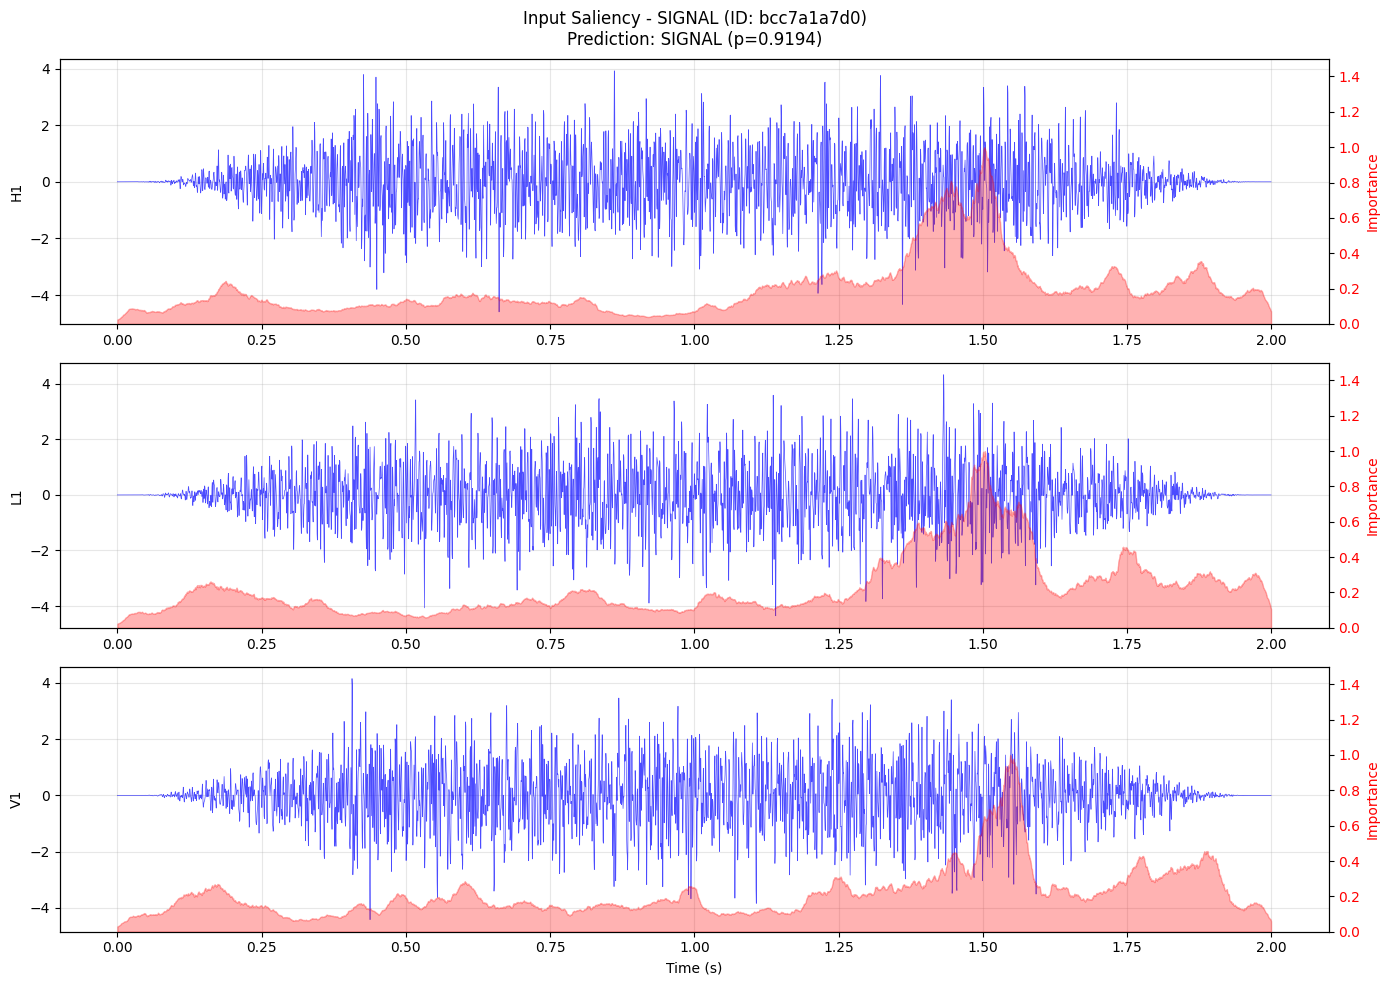

In [43]:
# Grad-CAM for signal sample
plot_gradcam(raw_signal, avg_psd, label_signal, id_signal, model)
plt.show()

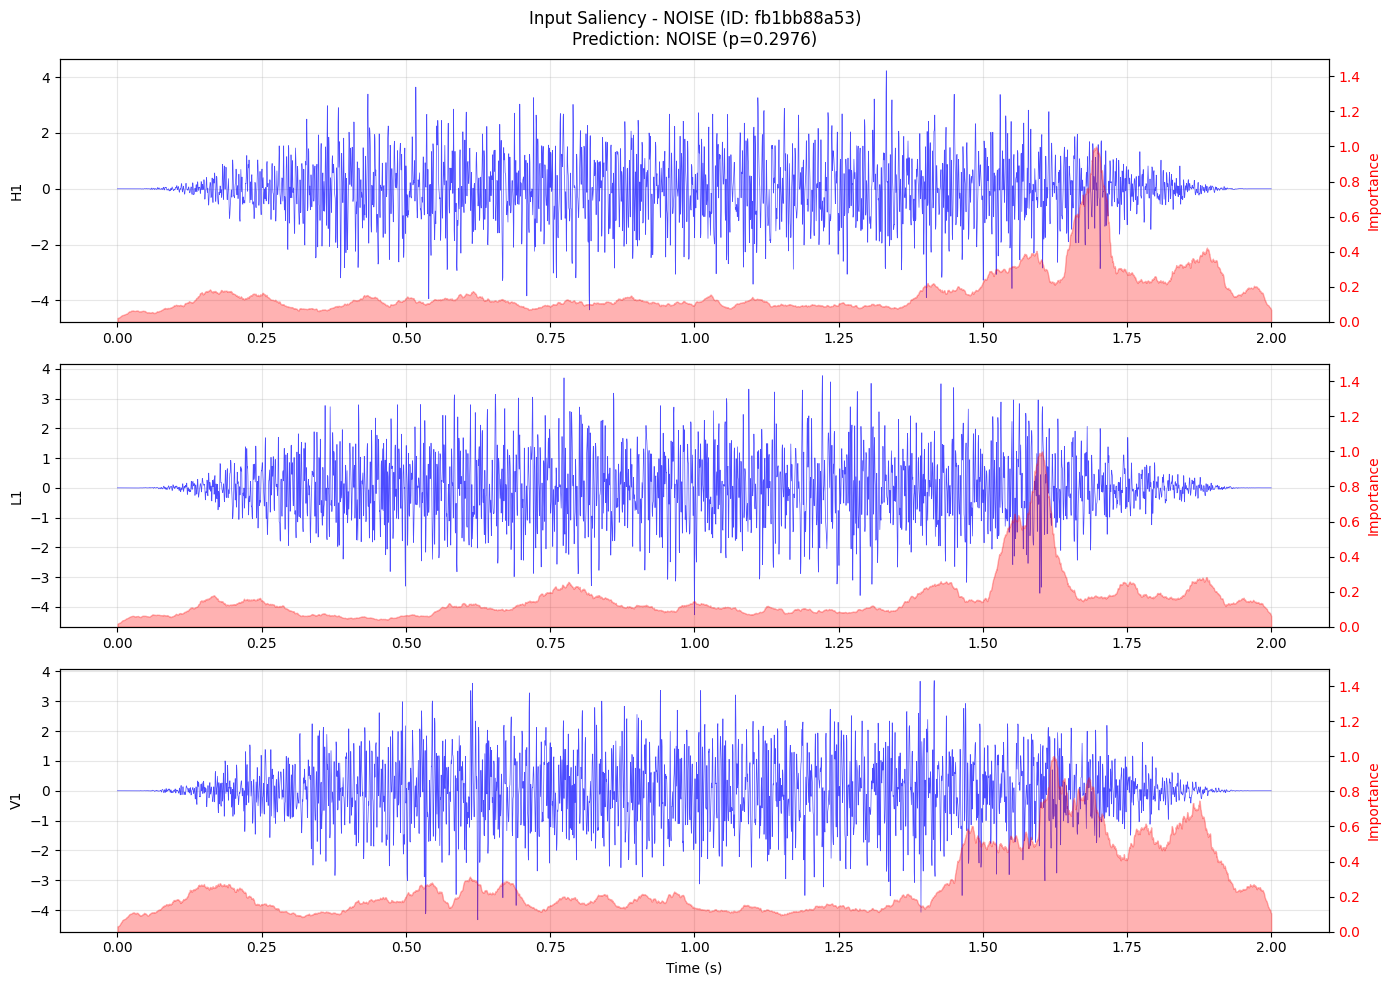

In [44]:
# Grad-CAM for noise sample
plot_gradcam(raw_noise, avg_psd, label_noise, id_noise, model)
plt.show()

## 6.2 Intermediate Activations

Visualize what each convolutional layer sees.

In [45]:
def get_layer_activations(model, X, detector_idx=0):
    """
    Get activations from each conv layer for visualization.
    
    Returns
    -------
    list of np.ndarray
        Activations from each conv layer
    """
    X_tensor = tf.convert_to_tensor(X[np.newaxis, ...], dtype=tf.float32)
    
    detector_signal = X_tensor[:, detector_idx, :]  # (1, 4096)
    x = tf.expand_dims(detector_signal, axis=-1)  # (1, 4096, 1)
    
    activations = []
    for i in range(len(model.conv_layers)):
        x = model._conv_block(x, i, training=False)
        activations.append(x.numpy()[0])  # remove batch dim
    
    return activations


def plot_activations(raw, avg_psd, label, sample_id, model, detector_idx=0, n_filters=8, figsize=(16, 12)):
    """
    Plot activations from each conv layer.
    """
    processed = preprocess_sample(raw, avg_psd)
    activations = get_layer_activations(model, processed, detector_idx=detector_idx)
    
    n_layers = len(activations)
    fig, axes = plt.subplots(n_layers, 1, figsize=figsize)
    
    for layer_idx, (ax, act) in enumerate(zip(axes, activations)):
        # act shape: (time_steps, n_filters)
        # show first n_filters as image
        n_show = min(n_filters, act.shape[1])
        
        im = ax.imshow(act[:, :n_show].T, aspect='auto', cmap='viridis')
        ax.set_ylabel(f'Layer {layer_idx+1}\n({act.shape[1]} filters)')
        ax.set_yticks(range(0, n_show, max(1, n_show//4)))
        
        if layer_idx == n_layers - 1:
            ax.set_xlabel('Time step')
    
    label_str = 'SIGNAL' if label == 1 else 'NOISE'
    fig.suptitle(f'Conv Layer Activations - {DETECTORS[detector_idx]} - {label_str}\n(ID: {sample_id})', fontsize=12)
    plt.tight_layout()
    
    return fig

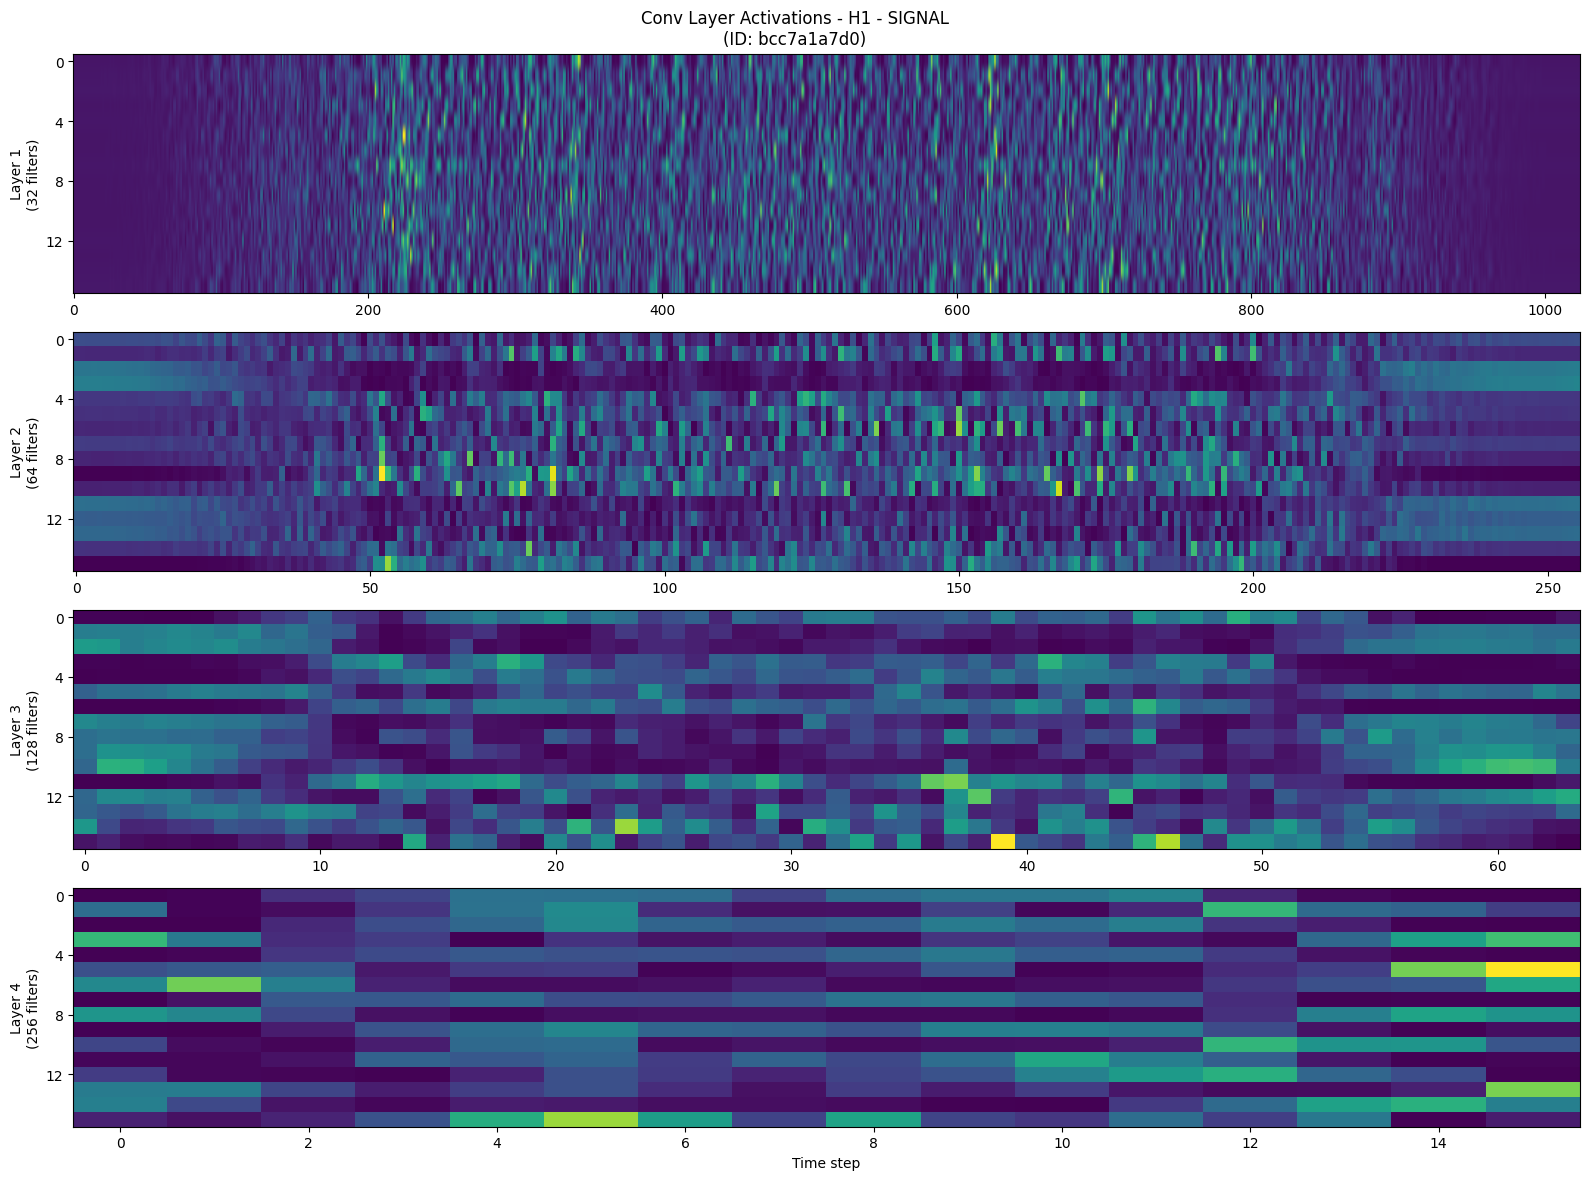

In [46]:
# activations for signal
plot_activations(raw_signal, avg_psd, label_signal, id_signal, model, detector_idx=0, n_filters=16)
plt.show()

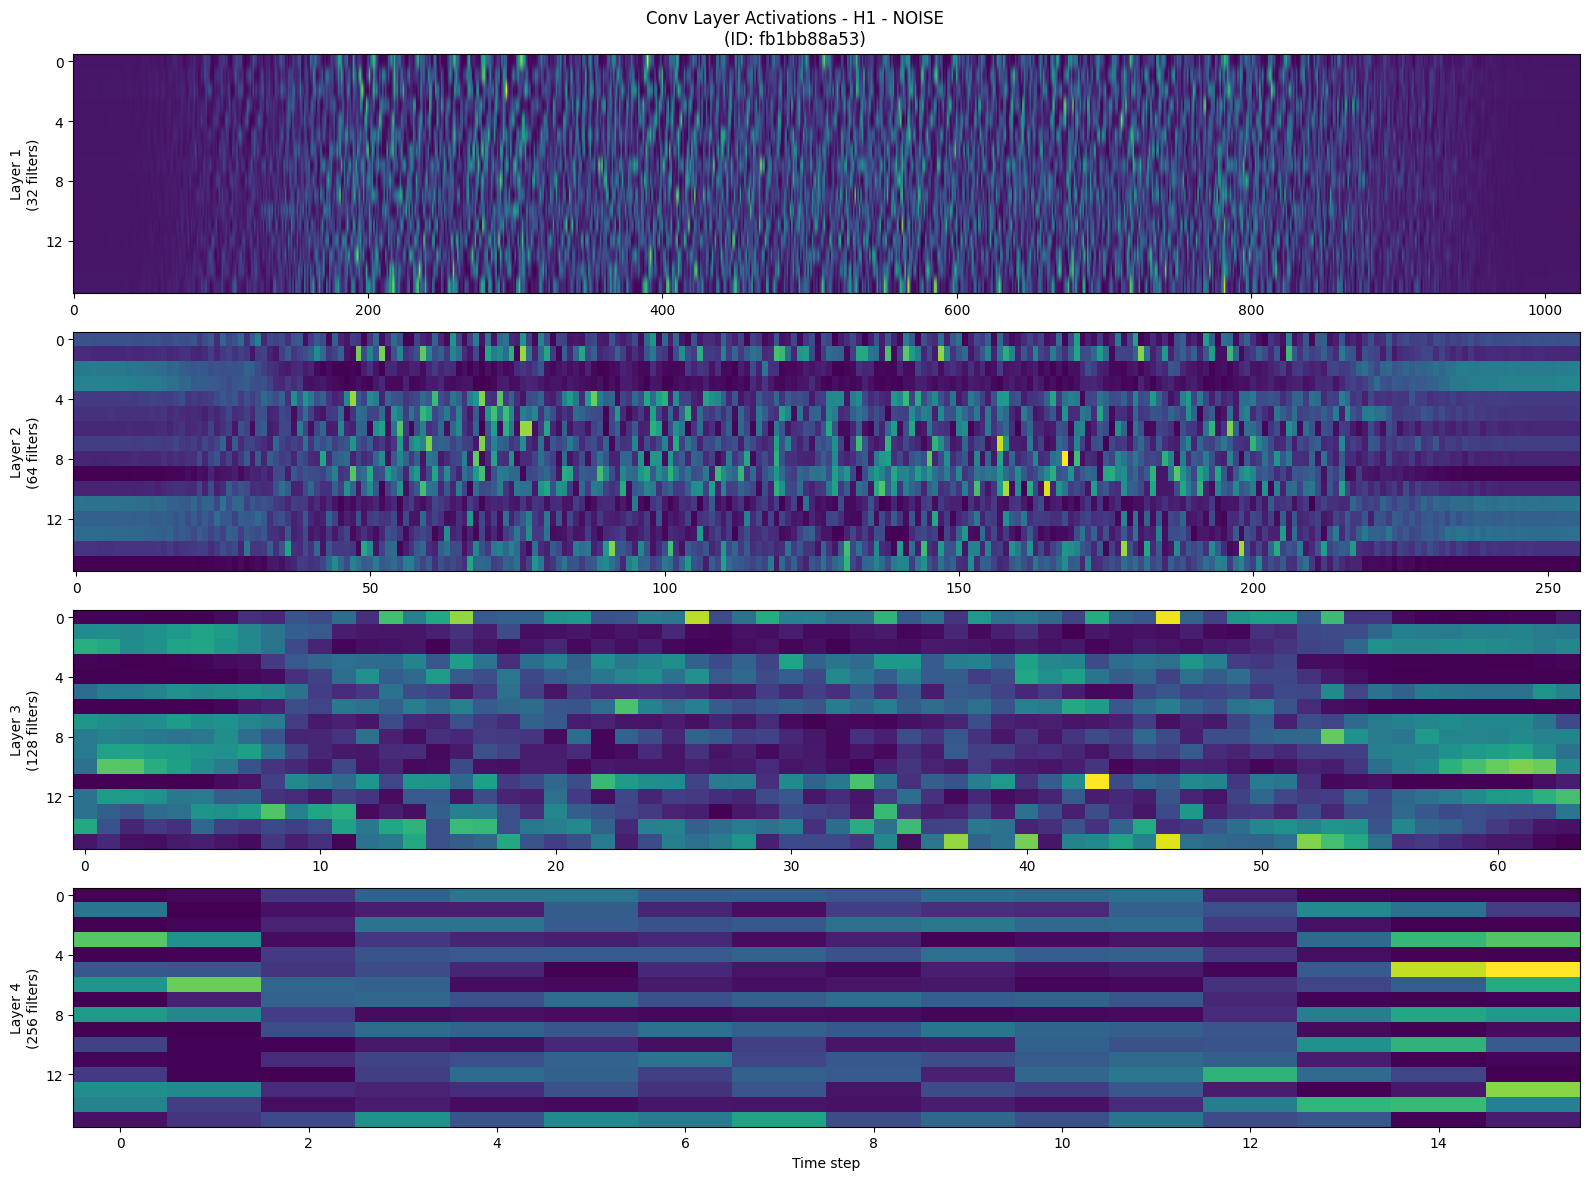

In [47]:
# activations for noise
plot_activations(raw_noise, avg_psd, label_noise, id_noise, model, detector_idx=0, n_filters=16)
plt.show()

## 6.3 Learned Filters

Visualize the learned convolutional filters (kernels).

In [48]:
def plot_learned_filters(model, layer_idx=0, n_filters=16, figsize=(14, 8)):
    """
    Plot learned filter weights from a conv layer.
    """
    W, b = model.conv_layers[layer_idx]
    weights = W.numpy()  # (kernel_size, in_channels, out_channels)
    
    kernel_size, in_channels, n_out_filters = weights.shape
    n_show = min(n_filters, n_out_filters)
    
    # for first layer, in_channels=1, so we can plot directly
    # for later layers, average across input channels
    if in_channels > 1:
        filter_vis = weights.mean(axis=1)  # average over input channels
    else:
        filter_vis = weights[:, 0, :]  # (kernel_size, n_filters)
    
    n_cols = 4
    n_rows = (n_show + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()
    
    for i in range(n_show):
        ax = axes[i]
        ax.plot(filter_vis[:, i], 'b-', linewidth=1.5)
        ax.set_title(f'Filter {i+1}', fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.set_xticks([])
    
    # hide unused subplots
    for i in range(n_show, len(axes)):
        axes[i].set_visible(False)
    
    filters_config = model.conv_config[layer_idx]
    fig.suptitle(f'Layer {layer_idx+1} Learned Filters\n(kernel_size={filters_config[1]}, n_filters={filters_config[0]})', fontsize=12)
    plt.tight_layout()
    
    return fig

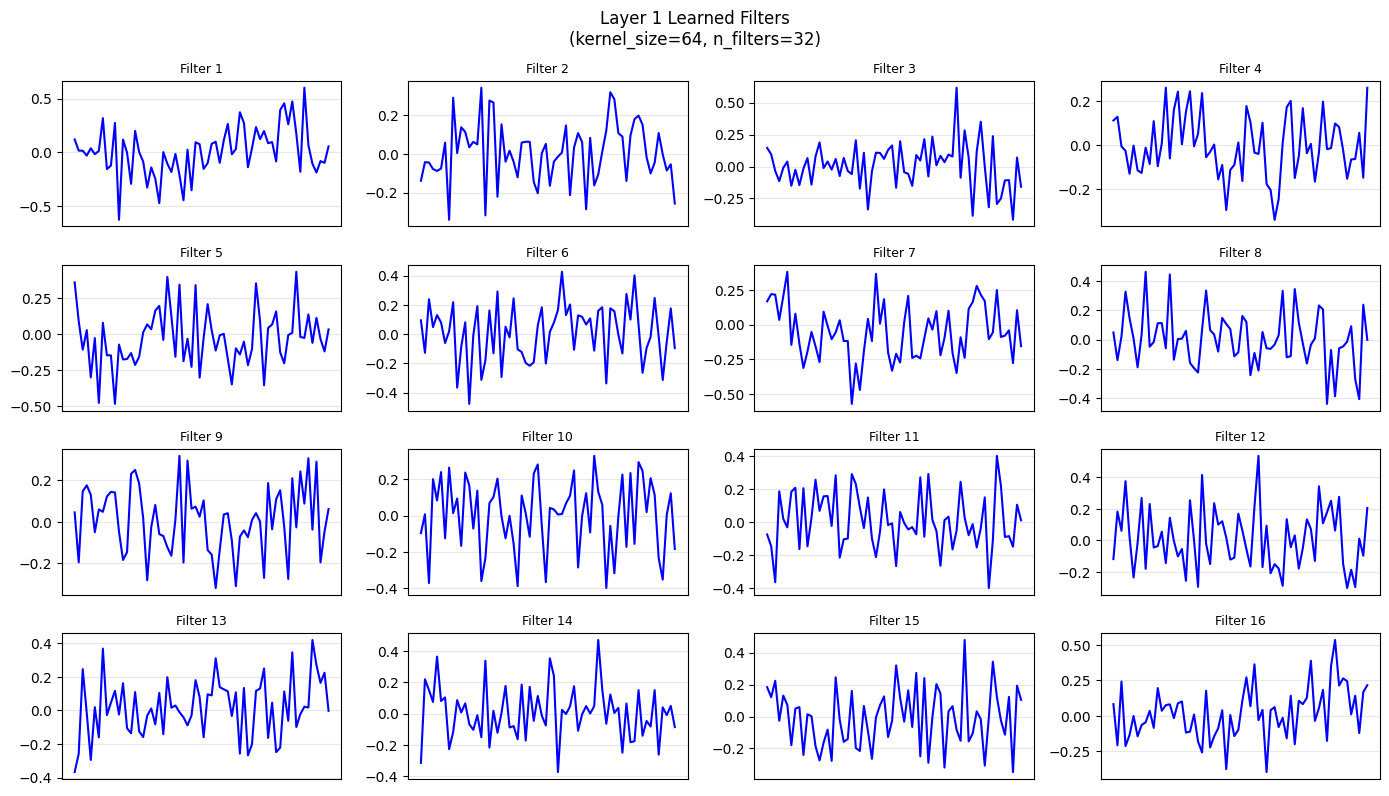

In [49]:
# first conv layer filters (large kernel, captures low-freq patterns)
plot_learned_filters(model, layer_idx=0, n_filters=16)
plt.show()

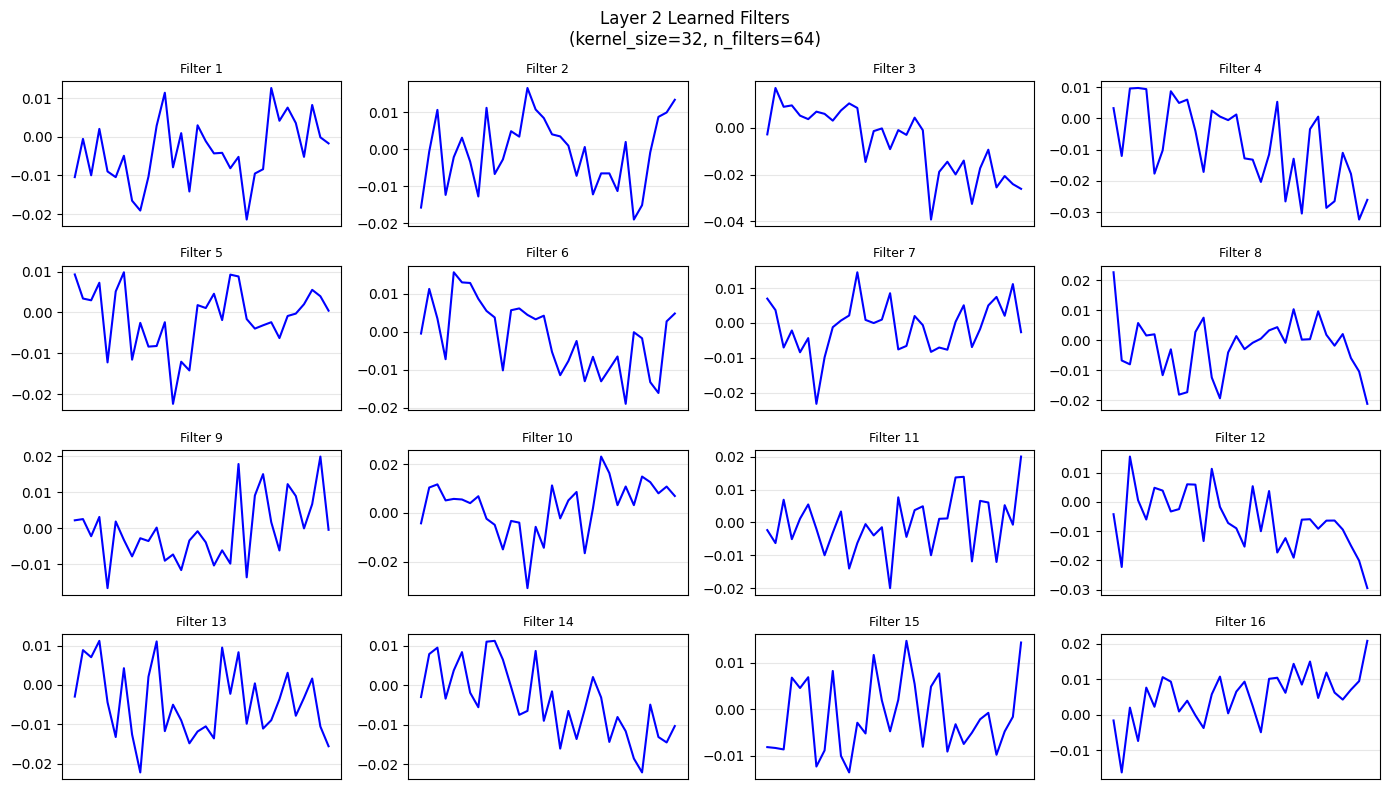

In [50]:
# second conv layer filters
plot_learned_filters(model, layer_idx=1, n_filters=16)
plt.show()

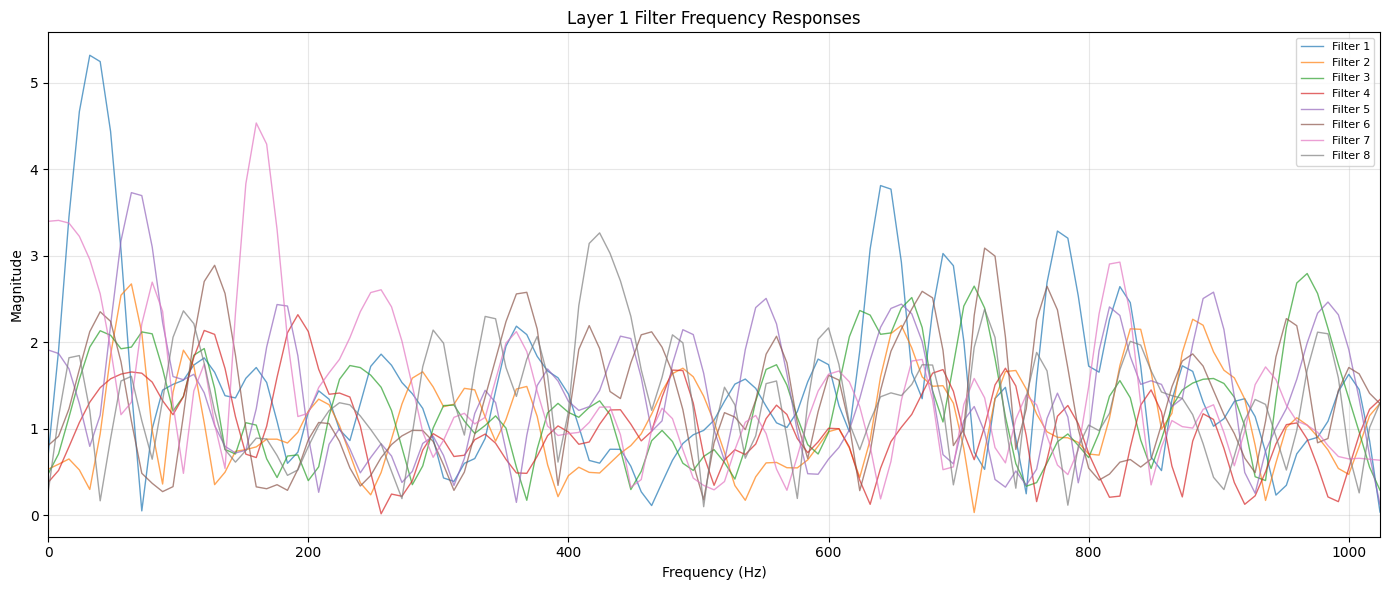

In [51]:
# filter frequency response
def plot_filter_frequency_response(model, layer_idx=0, n_filters=8, figsize=(14, 6)):
    """
    Plot frequency response of learned filters.
    """
    W, _ = model.conv_layers[layer_idx]
    weights = W.numpy()
    
    kernel_size, in_channels, n_out_filters = weights.shape
    n_show = min(n_filters, n_out_filters)
    
    if in_channels > 1:
        filter_vis = weights.mean(axis=1)
    else:
        filter_vis = weights[:, 0, :]
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # compute FFT of each filter
    for i in range(n_show):
        fft_vals = np.abs(np.fft.rfft(filter_vis[:, i], n=256))
        freqs = np.fft.rfftfreq(256, d=1/FS)
        ax.plot(freqs, fft_vals, linewidth=1, alpha=0.7, label=f'Filter {i+1}')
    
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Magnitude')
    ax.set_title(f'Layer {layer_idx+1} Filter Frequency Responses')
    ax.set_xlim([0, FS/2])
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig


plot_filter_frequency_response(model, layer_idx=0, n_filters=8)
plt.show()

# ============================================================================================
#                          SECTION 7: INTERACTIVE PLAYGROUND
# ============================================================================================

In [52]:
def full_analysis(sample_id=None, sample_type='any', detector_idx=0):
    """
    Run complete analysis pipeline on a single sample.
    
    Parameters
    ----------
    sample_id : str, optional
        Specific sample ID. If None, selects randomly.
    sample_type : str
        'signal', 'noise', or 'any' (ignored if sample_id is provided)
    detector_idx : int
        Which detector to focus on for single-detector plots
    """
    # load sample
    if sample_id is not None:
        row = labels_df[labels_df['id'] == sample_id].iloc[0]
        label = row['target']
    else:
        if sample_type == 'signal':
            row = labels_df[labels_df['target'] == 1].sample(1).iloc[0]
        elif sample_type == 'noise':
            row = labels_df[labels_df['target'] == 0].sample(1).iloc[0]
        else:
            row = labels_df.sample(1).iloc[0]
        sample_id = row['id']
        label = row['target']
    
    raw = load_sample(sample_id, dataset_dir=dataset_dir)
    
    print("="*70)
    print(f"FULL ANALYSIS: {sample_id}")
    print("="*70)
    
    # prediction
    prob, pred, _ = predict_single_sample(model, raw, avg_psd)
    label_str = 'SIGNAL' if label == 1 else 'NOISE'
    pred_str = 'SIGNAL' if pred == 1 else 'NOISE'
    correct = label == pred
    
    print(f"\nPREDICTION:")
    print(f"  Actual class:         {label_str}")
    print(f"  Predicted class:      {pred_str}")
    print(f"  Probability (signal): {prob:.4f}")
    print(f"  Result:               {'CORRECT' if correct else 'WRONG'}")
    print()
    
    # create comprehensive figure
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)
    
    processed = preprocess_sample(raw, avg_psd)
    time = np.arange(N) / FS
    
    # row 1: raw waveforms (3 plots)
    for i in range(3):
        ax = fig.add_subplot(gs[0, i])
        ax.plot(time, raw[i], 'b-', linewidth=0.3)
        ax.set_title(f'Raw - {DETECTORS[i]}')
        ax.set_xlabel('Time (s)')
        ax.grid(True, alpha=0.3)
    
    # row 1, col 4: prediction gauge
    ax = fig.add_subplot(gs[0, 3])
    ax.barh([0], [prob], color='red' if prob > 0.5 else 'blue', alpha=0.7)
    ax.axvline(x=0.5, color='black', linestyle='--')
    ax.set_xlim([0, 1])
    ax.set_yticks([])
    ax.set_xlabel('Probability')
    ax.set_title(f'Prediction: {pred_str}\n(p={prob:.4f})')
    
    # row 2: preprocessed waveforms
    for i in range(3):
        ax = fig.add_subplot(gs[1, i])
        ax.plot(time, processed[i], 'b-', linewidth=0.3)
        ax.set_title(f'Preprocessed - {DETECTORS[i]}')
        ax.set_xlabel('Time (s)')
        ax.grid(True, alpha=0.3)
    
    # row 2, col 4: cross-correlation summary
    ax = fig.add_subplot(gs[1, 3])
    pairs = [(0, 1, 'H1-L1'), (0, 2, 'H1-V1'), (1, 2, 'L1-V1')]
    corr_peaks = []
    for i, j, name in pairs:
        _, corr = compute_cross_correlation(processed[i], processed[j], max_lag=50)
        corr_peaks.append(np.max(np.abs(corr)))
    ax.bar([p[2] for p in pairs], corr_peaks, color='steelblue')
    ax.set_ylabel('Peak Correlation')
    ax.set_title('Cross-Detector Correlation')
    ax.grid(True, alpha=0.3)
    
    # row 3: Q-transform for each detector
    for i in range(3):
        ax = fig.add_subplot(gs[2, i])
        times_q, freqs_q, qt = compute_qtransform(processed[i])
        ax.pcolormesh(times_q, freqs_q, qt, shading='auto', cmap='viridis')
        ax.set_yscale('log')
        ax.set_title(f'Q-Transform - {DETECTORS[i]}')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Freq (Hz)')
    
    # row 3, col 4: layer activations summary
    ax = fig.add_subplot(gs[2, 3])
    activations = get_layer_activations(model, processed, detector_idx=detector_idx)
    # show mean activation per layer
    mean_acts = [act.mean() for act in activations]
    ax.bar(range(1, len(mean_acts)+1), mean_acts, color='purple', alpha=0.7)
    ax.set_xlabel('Conv Layer')
    ax.set_ylabel('Mean Activation')
    ax.set_title('Layer Activations')
    ax.grid(True, alpha=0.3)
    
    # row 4: Grad-CAM for each detector
    for i in range(3):
        ax = fig.add_subplot(gs[3, i])
        heatmap, _ = compute_gradcam(model, processed, target_detector=i)
        ax.plot(time, processed[i], 'b-', linewidth=0.3, alpha=0.7)
        ax2 = ax.twinx()
        ax2.fill_between(time, 0, heatmap, alpha=0.3, color='red')
        ax2.set_ylim([0, 1.5])
        ax.set_title(f'Grad-CAM - {DETECTORS[i]}')
        ax.set_xlabel('Time (s)')
        ax.grid(True, alpha=0.3)
    
    # row 4, col 4: summary text
    ax = fig.add_subplot(gs[3, 3])
    ax.axis('off')
    summary_text = f"""
    SUMMARY
    -------
    Sample ID: {sample_id}
    
    Actual: {label_str}
    Predicted: {pred_str}
    Probability: {prob:.4f}
    Result: {'CORRECT' if correct else 'WRONG'}
    
    Cross-correlation peaks:
      H1-L1: {corr_peaks[0]:.3f}
      H1-V1: {corr_peaks[1]:.3f}
      L1-V1: {corr_peaks[2]:.3f}
    """
    ax.text(0.1, 0.9, summary_text, transform=ax.transAxes, 
            verticalalignment='top', fontsize=10, family='monospace')
    
    fig.suptitle(f'Complete Analysis - {sample_id} ({label_str})', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return sample_id, label, prob, pred

FULL ANALYSIS: fac5791f7b

PREDICTION:
  Actual class:         SIGNAL
  Predicted class:      SIGNAL
  Probability (signal): 0.9672
  Result:               CORRECT



C:\Users\jose\AppData\Local\Temp\ipykernel_26576\2745813558.py:146: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


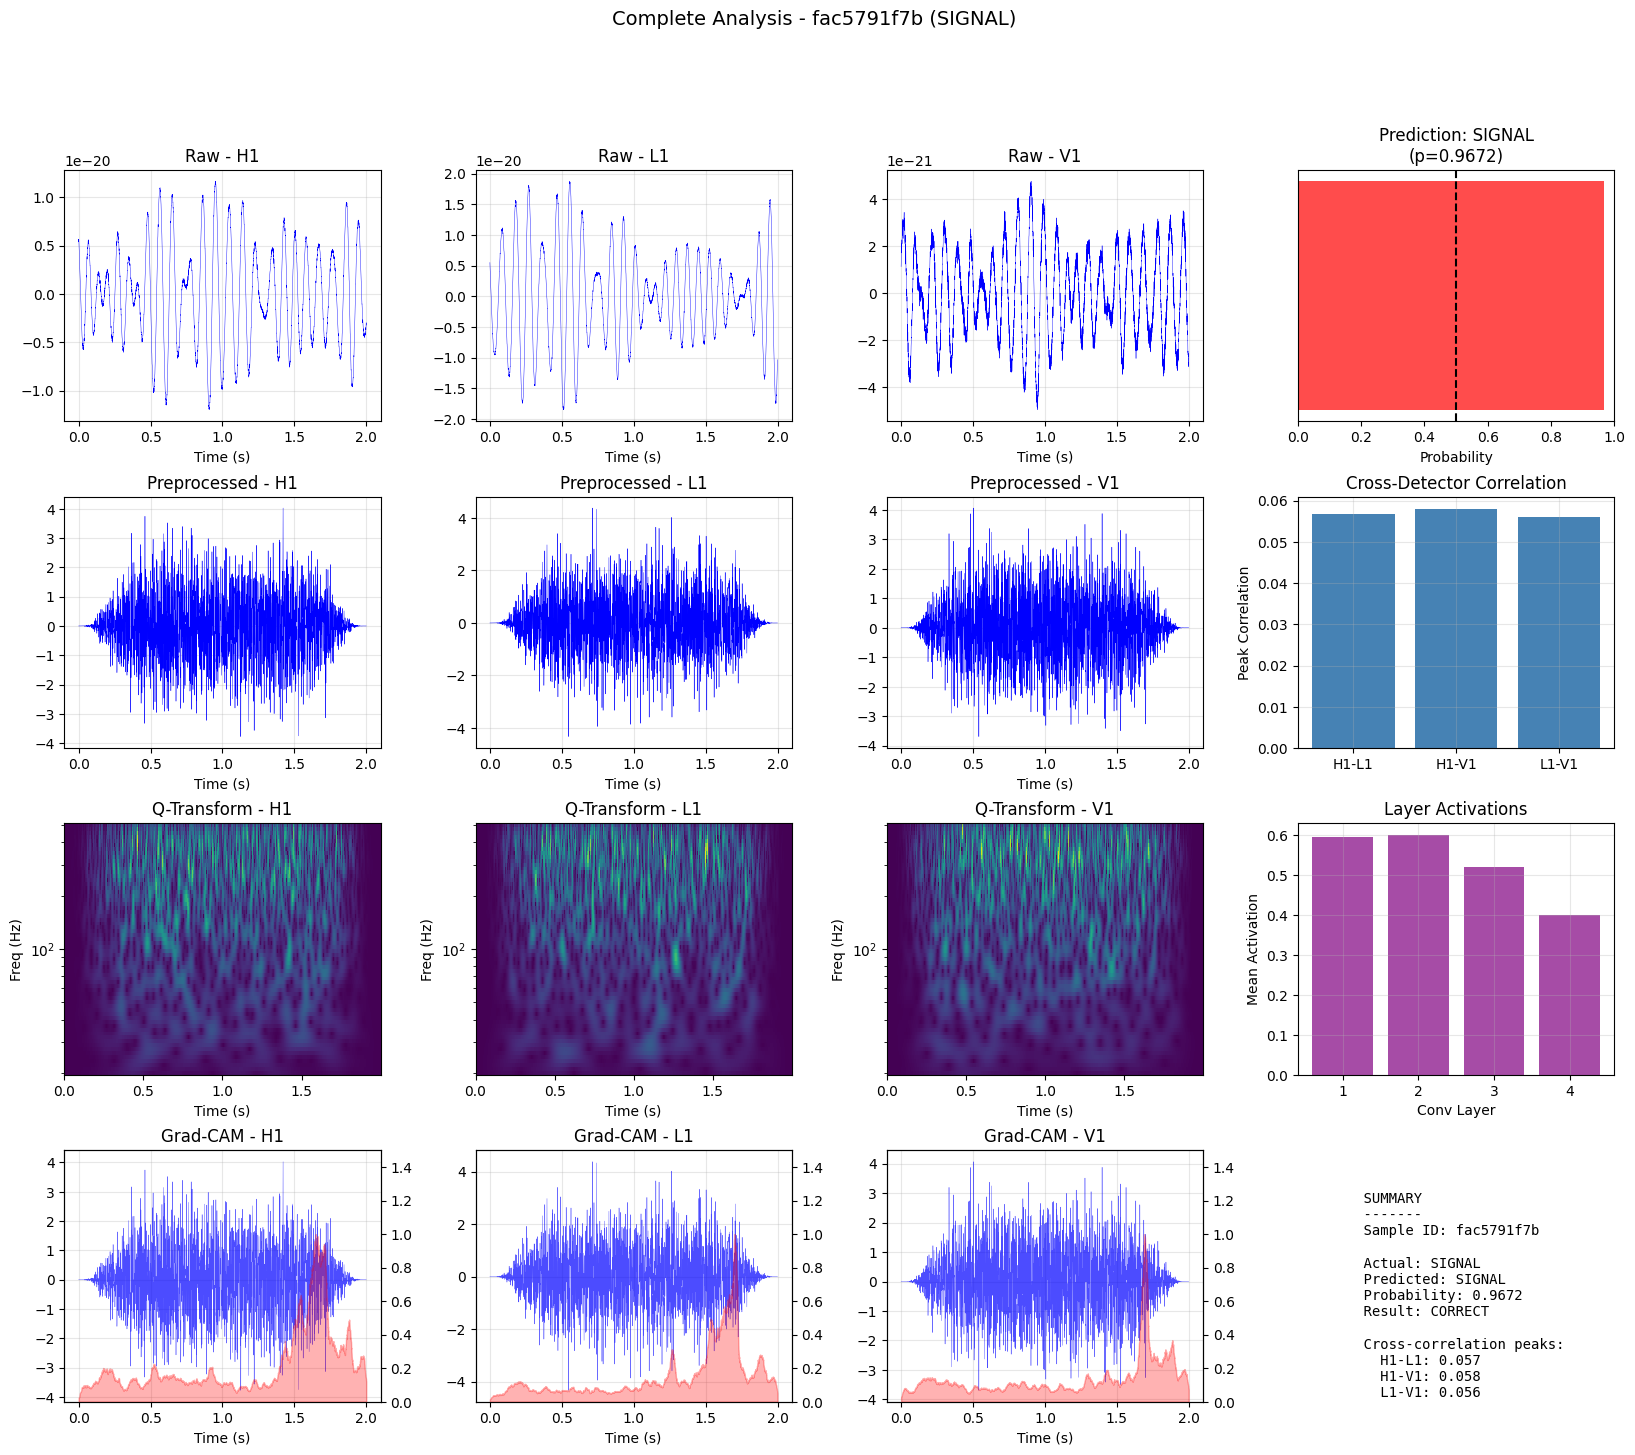

('fac5791f7b', np.int64(1), np.float32(0.96723163), 1)

In [53]:
# analyze a random signal
full_analysis(sample_type='signal')

FULL ANALYSIS: 5e88699a3b

PREDICTION:
  Actual class:         SIGNAL
  Predicted class:      SIGNAL
  Probability (signal): 0.9990
  Result:               CORRECT



C:\Users\jose\AppData\Local\Temp\ipykernel_26576\2745813558.py:146: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


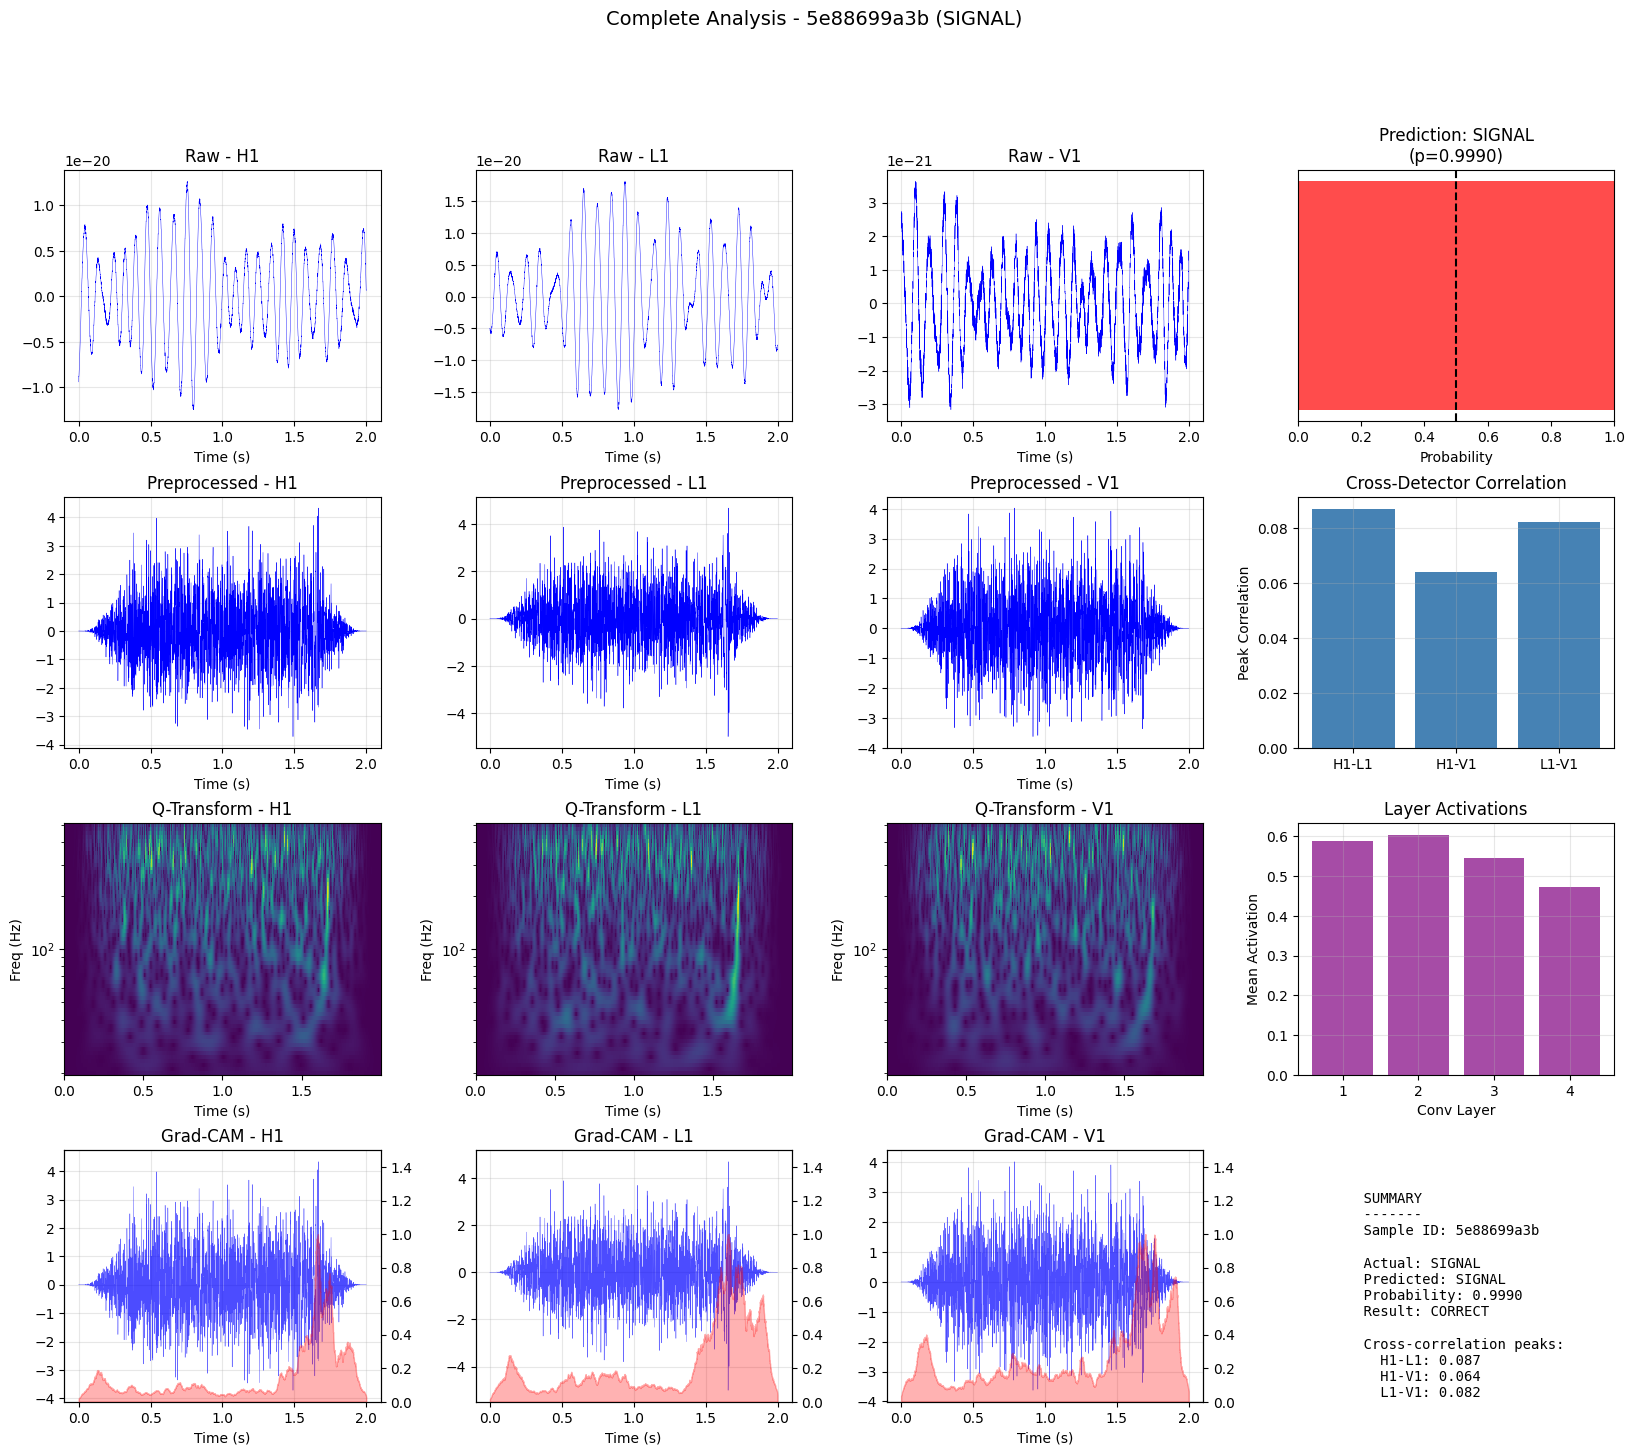

('5e88699a3b', np.int64(1), np.float32(0.9989537), 1)

In [58]:
# analyze a random noise sample
full_analysis(sample_type='signal')

In [55]:
# analyze a specific sample by ID
# full_analysis(sample_id='your_sample_id_here')

Analyzing a false negative (signal predicted as noise):
FULL ANALYSIS: 3f3e77cd25

PREDICTION:
  Actual class:         SIGNAL
  Predicted class:      NOISE
  Probability (signal): 0.1097
  Result:               WRONG



C:\Users\jose\AppData\Local\Temp\ipykernel_26576\2745813558.py:146: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


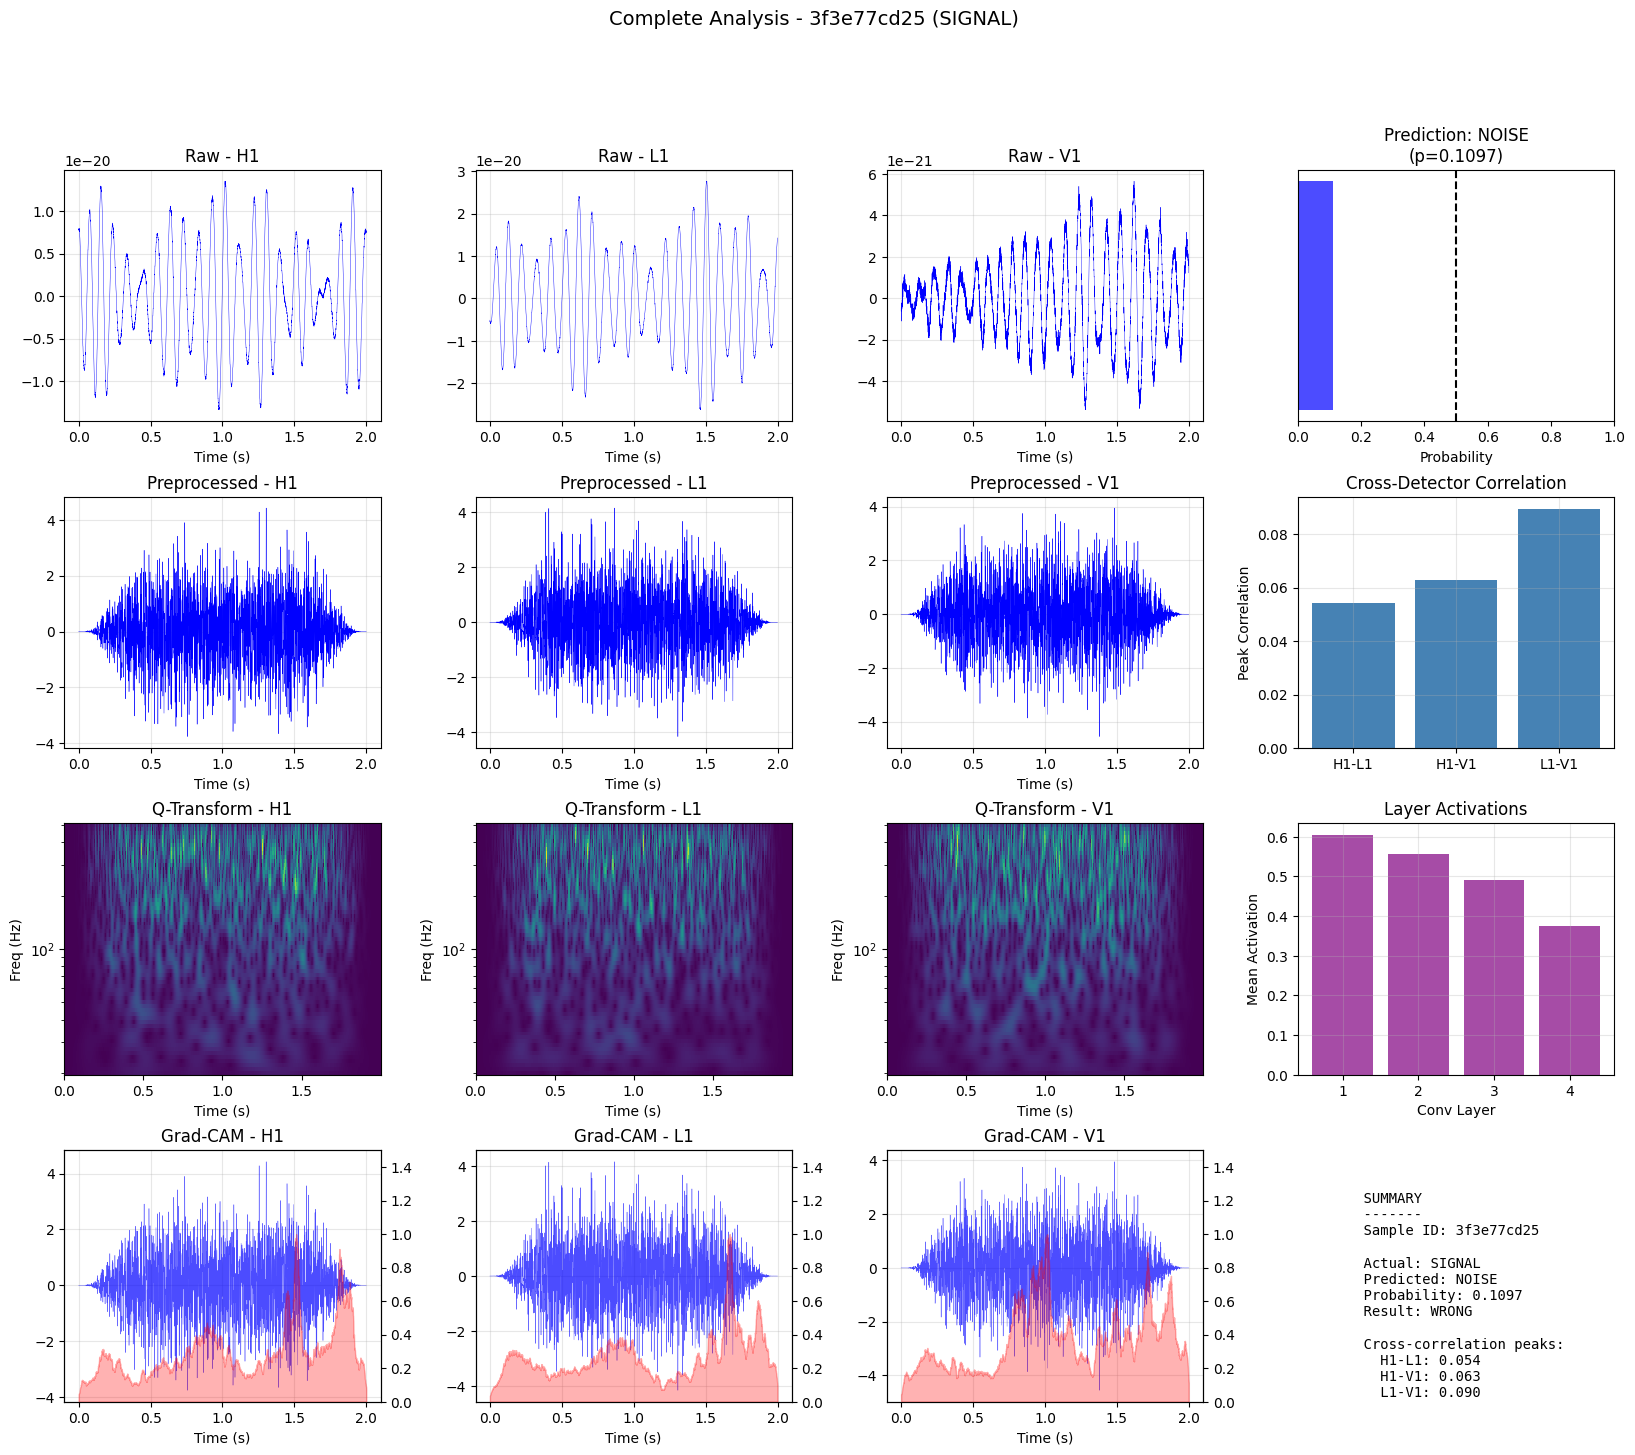

In [56]:
# analyze a misclassified sample
if X_val is not None and false_negatives:
    fn_id = false_negatives[0][0]
    print("Analyzing a false negative (signal predicted as noise):")
    full_analysis(sample_id=fn_id)

# ============================================================================================
#                                      END
# ============================================================================================